In [1]:
import scanpy.api as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from collections import Counter
import seaborn as sns
sc.settings.verbosity = 0 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=170, color_map='viridis')  # low dpi (dots per inch) yields small inline figures
sc.logging.print_versions()
results_file = './intestine_cells.h5ad'
results_file_denoised = './intestine_cells_demo.h5ad'

scanpy==1.4.1 anndata==0.6.21 numpy==1.16.4 scipy==1.2.1 pandas==0.24.2 scikit-learn==0.21.2 statsmodels==0.10.0rc2 python-igraph==0.7.1 louvain==0.6.1 


To begin, we will point to the directory produced by cellranger (or desired published dataset) that contains the following:
1. A barcodes.tsv file
2. A genes.tsv file
3. A matrix.mtx file

^The above is always true when using data from 10x. If using data produced via packages other than cellranger such as FeatureCounts or DESeq2, read the data in using python's pandas package.

At the bare bones, what you need is a counts matrix. This matrix contains the number of read counts for each gene for each cell. While cellranger outputs this as a .mtx file, you can also read files that are excel spreadsheets, text files, etc. See scanpy's documentation for this: https://scanpy.readthedocs.io/en/latest/api/index.html#reading

We are going to use Scanpy's "read_10x_mtx" function because we are reading in a 10X mtx file to analyze.

## Starting from 10X Dataset

In [2]:
adata = sc.read_10x_mtx('/oasis/tscc/scratch/CSHL_single_cell_2019/scanpy/data/GSM2836574_Regional_Duo_M2/',
                       var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
                        cache=True)

In [3]:
adata

AnnData object with n_obs × n_vars = 2206 × 27998 
    var: 'gene_ids'

## Preprocessing

The preprocessing can be done somewhere else (such as in R) and then loaded into scanpy. If this is your situation, skip this portion. You can also freeze the raw data at any point if you want to come back to it. Set the .raw attribute of AnnData object to the logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This simply freezes the state of the AnnData object returned by sc.pp.log1p.

Take a quick look at the genes with the highest fraction of counts in each cell, across all cells

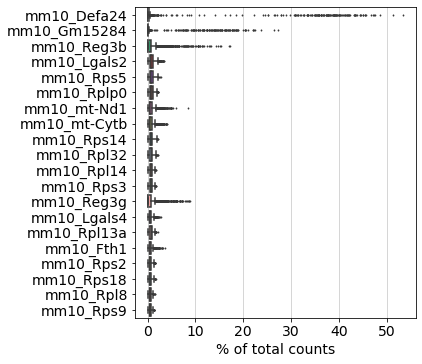

In [4]:
sc.pl.highest_expr_genes(adata, n_top=20)

Do some basic filtering:

In [5]:
sc.pp.filter_cells(adata, min_genes=800)

In [6]:
sc.pp.filter_genes(adata, min_cells=3)

In [7]:
sc.pp.filter_genes(adata, min_counts=15)

Let's see how many genes ('n_vars') we have

In [8]:
adata.n_vars

10772

Let's see how many cells ('n_obs') we have

In [9]:
adata.n_obs

2061

Let us assemble some information about mitochondrial genes, which are important for quality control.

Citing from “Simple Single Cell” workflows (Lun, McCarthy & Marioni, 2017):

High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

In this dataset, all genes are prefixed with 'mm10_'. Additionally, mitochondrial genes are annotated with the prefix 'mt-'. So we will call any gene with the prefix 'mm10_mt-' as a mitochondrial gene. For your own research, if you are working with human cells, mitochondrial genes are prefixed with 'MT-'

In [10]:
mito_genes = adata.var_names.str.startswith('mm10_mt-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

In [11]:
adata.obs.head()

,n_genes,percent_mito,n_counts
0,,,
AAACATTGCCATAG-1,1337,0.022239,3912.0
AAACCGTGAAGGGC-1,1667,0.010335,4064.0
AAACCGTGCCTTAT-1,1013,0.000487,26713.0
AAACGCTGAAACGA-1,1698,0.010733,4472.0
AAACGCTGAACCTG-1,1803,0.019840,4133.0


A violin plot of the computed quality measures.

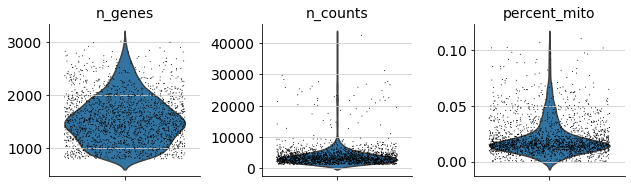

In [12]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts.

/opt/conda/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/opt/conda/lib/python3.6/site-packages/anndata/base.py:1618: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/opt/conda/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
/opt/conda/lib/python3.6/site-packages/anndata/base.py:1618: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


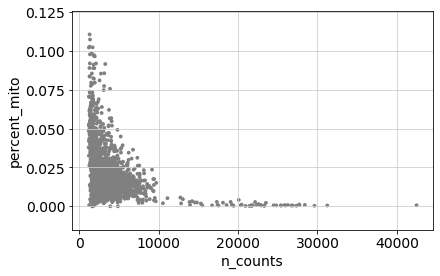

/opt/conda/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/opt/conda/lib/python3.6/site-packages/anndata/base.py:1618: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/opt/conda/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
/opt/conda/lib/python3.6/site-packages/anndata/base.py:1618: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning


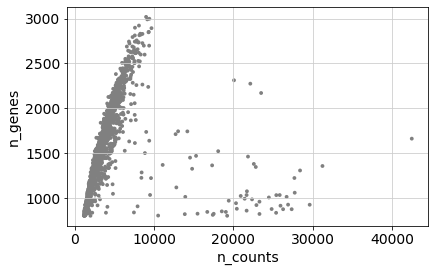

In [13]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

Actually do the filtering.

In [14]:
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

Total-count normalize (library-size correct) the data matrix to 10,000 reads per cell, so that counts become comparable among cells. Then log normalize the counts.

In [15]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

Trying to set attribute `.obs` of view, making a copy.


Now we filter the data for the most variable genes

In [16]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

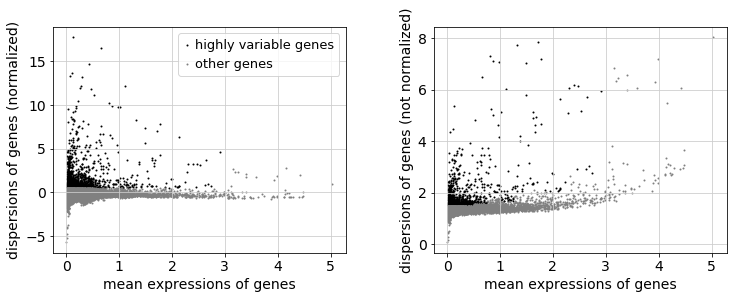

In [17]:
sc.pl.highly_variable_genes(adata)

Now do the filtering

In [18]:
adata = adata[:, adata.var['highly_variable']]

In [19]:
adata

View of AnnData object with n_obs × n_vars = 1855 × 1480 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

We used to have 11k genes and now we are at 1855

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [20]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

Scale each gene to unit variance. Clip values exceeding standard deviation 10.

In [21]:
sc.pp.scale(adata, max_value=10)

EXCERCISE: Check the top 20 highly expressed genes in our data now that we've filtered it (hint: look for the commands we used early in the notebook)

In [69]:
# Do your code stuff here

## PCA

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises (noise reduction) the data.

In [22]:
sc.tl.pca(adata, svd_solver='arpack')

We can make a scatter plot in the PCA coordinates, but we will not use that later on.

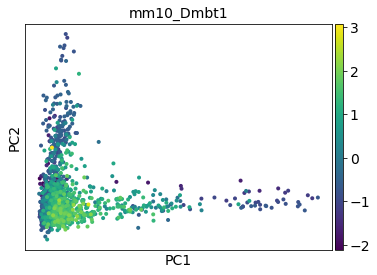

In [23]:
sc.pl.pca(adata, color='mm10_Dmbt1')

If we want we can add additional genes to look at

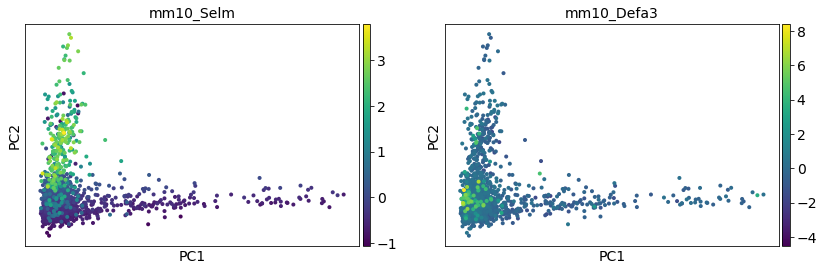

In [24]:
sc.pl.pca(adata, color=['mm10_Selm','mm10_Defa3'])

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function sc.tl.louvain() or tSNE sc.tl.tsne(). Usually, a rough estimate of the number of PCs does fine.

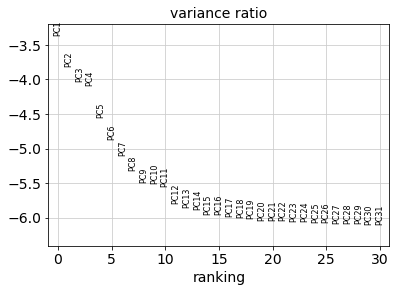

In [25]:
sc.pl.pca_variance_ratio(adata, log=True)

What we are looking for is how many principle components to use in the future computation of our neighborhood graphs. We can see from the graph above that we capture almost all of the varaiance in the first 10 principle components so that is the number we will use going forward.

Now lets save the results

In [26]:
adata.write(results_file)

In [27]:
adata

AnnData object with n_obs × n_vars = 1855 × 1480 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Computing the neighborhood graph

Using the PCA representation of the data matrix we can now compute the neighborhood graph. This means that we are estimating how connected all of the data points are - the connectivity of the manifold.

Scanpy pp.neighbors relies heavily on UMAP and the n_neighbors integer is the size of local neighborhood (in terms of number of neighboring data points) used for manifold approximation. Larger values result in more global views of the manifold, while smaller values result in more local data being preserved.

In [28]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)

## Embedding the neighborhood graph

An embedding is a representation of a topological object, manifold, graph, field, etc. in a certain space in such a way that its connectivity or algebraic properties are preserved. Scanpy offers several flavors with different advantages and disadvantages to each: PCA, tSNE, UMAP, Force-directed, and Diffusion Maps. 

First we will try to UMAP (McInnes et al., 2018) https://arxiv.org/abs/1802.03426

In [29]:
sc.tl.umap(adata)

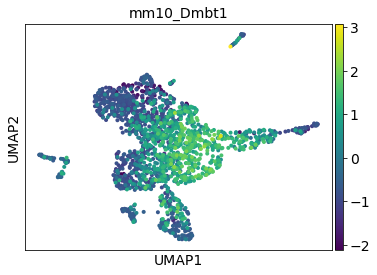

In [30]:
sc.pl.umap(adata,color='mm10_Dmbt1')

If we knew something about these cells before sequencing we could add annotation and color the cells by that annotation. We can change some of the plotting parameters like this:

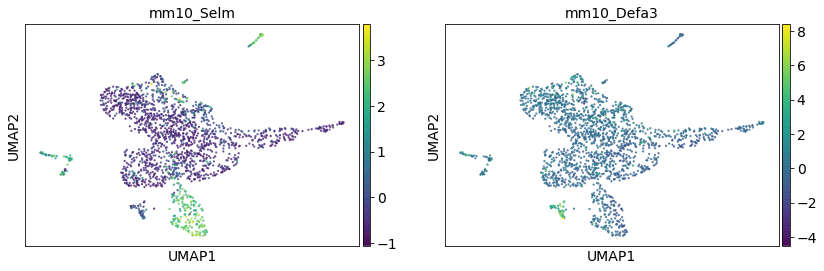

In [31]:
sc.pl.umap(adata, color=['mm10_Selm','mm10_Defa3'],legend_fontsize=7, alpha=0.8, size=20)

If you also wanted to try the Force-directed graph drawing [Islam11] [Jacomy14] [Chippada18]. An alternative to tSNE that often preserves the topology of the data better. This requires to run neighbors(), first.

In [32]:
sc.tl.draw_graph(adata, layout='fr')

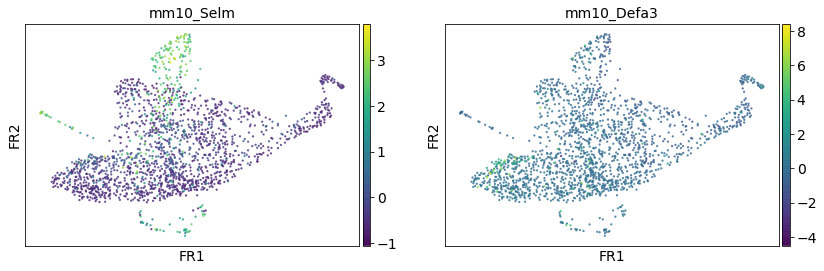

In [33]:
#sc.pl.draw_graph(adata, color=['mm10_Zfos1','mm10_Selm','mm10_Defa3'], legend_fontsize=7, alpha=0.8, size=20)
sc.pl.draw_graph(adata, color=['mm10_Selm','mm10_Defa3'], legend_fontsize=7, alpha=0.8, size=20)

Alternatively, if you want to produce a tSNE you can do the following:

In [34]:
sc.tl.tsne(adata, n_pcs = 10, early_exaggeration = 5)

There are several settings when computing tSNE but two are perplexity: "The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. The choice is not extremely critical since t-SNE is quite insensitive to this parameter." 
and early_exaggeration: "Controls how tight natural clusters in the original space are in the embedded space and how much space will be between them. For larger values, the space between natural clusters will be larger in the embedded space. Again, the choice of this parameter is not very critical. If the cost function increases during initial optimization, the early exaggeration factor or the learning rate might be too high."

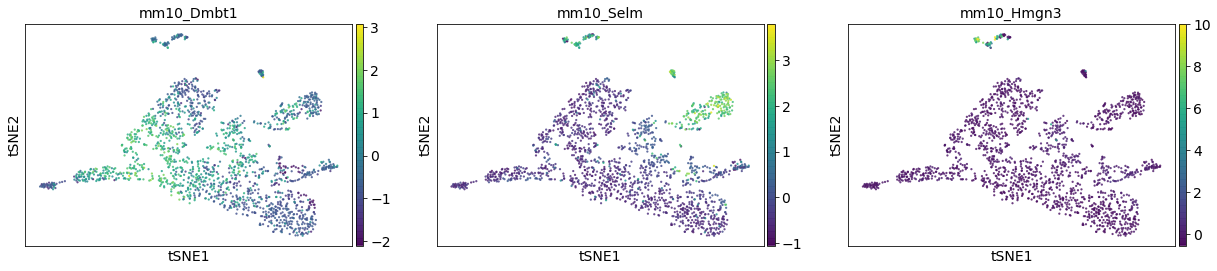

In [35]:
sc.pl.tsne(adata, color=['mm10_Dmbt1','mm10_Selm','mm10_Hmgn3'], legend_loc='on data', legend_fontsize=7, alpha=0.8, size=20)




## Clustering the neighborhood graph

Seurat and many others recommend the Louvain graph-clustering method (community detection based on optimizing modularity). It has been proposed for single-cell data by Levine et al. (2015). Note that Louvain clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [36]:
sc.tl.louvain(adata)

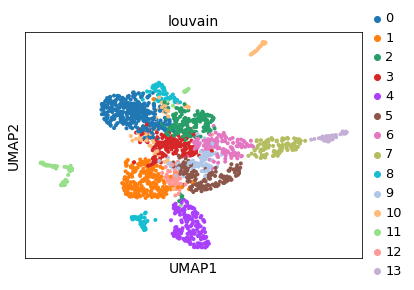

In [37]:
sc.pl.umap(adata, color='louvain')

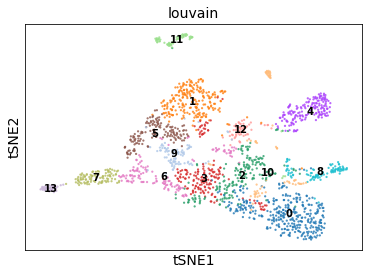

In [38]:
sc.pl.tsne(adata, color='louvain', legend_loc='on data', legend_fontsize=10, alpha=0.8, size=20)

When looking at both the UMAP and tSNE it looks to me like 13 clusters is a little ambitious. So if we want to recluster with a lower resolution we will get less clusters (1 is the default)

In [39]:
sc.tl.louvain(adata, resolution = 0.25)

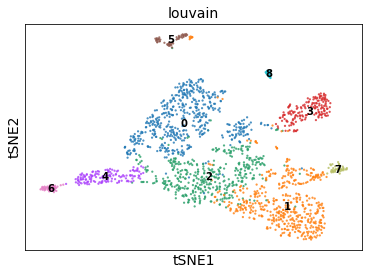

In [40]:
sc.pl.tsne(adata, color='louvain', legend_loc='on data', legend_fontsize=10, alpha=0.8, size=20)

Save the clustering graph to a pdf and then save the file.

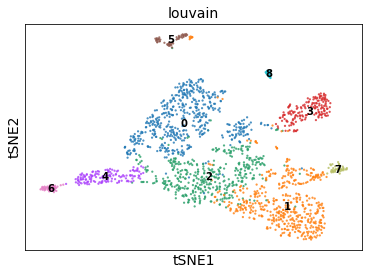

In [41]:
sc.pl.tsne(adata, color=['louvain'], legend_loc='on data', legend_fontsize=10, alpha=0.8, size=20, save = 'tsne_lovain_res0_25.pdf')

In [42]:
adata.write(results_file)

## Finding Marker Genes

The easiest way to do this is using a t-test to find differentially expressed genes between one cluster and all of the other clusters.

/opt/conda/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:224: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


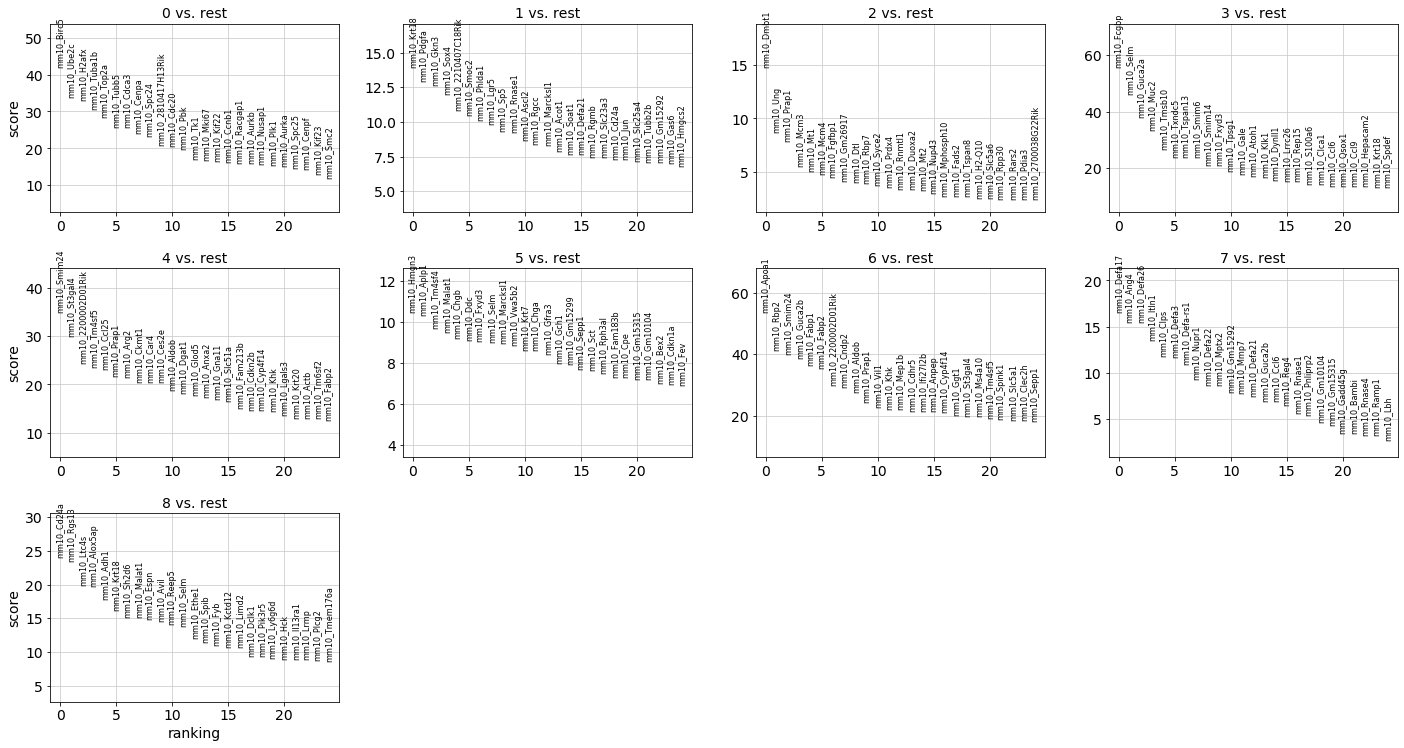

In [43]:
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Check out a detailed explanation of the wilcoxin rank sum test [here](https://www.stat.auckland.ac.nz/~wild/ChanceEnc/Ch10.wilcoxon.pdf). 

The t-test assumes your data is normally distributed. This is often not the case. For a non-parametric test we can then use the Mann-Whitney test.

/opt/conda/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:389: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


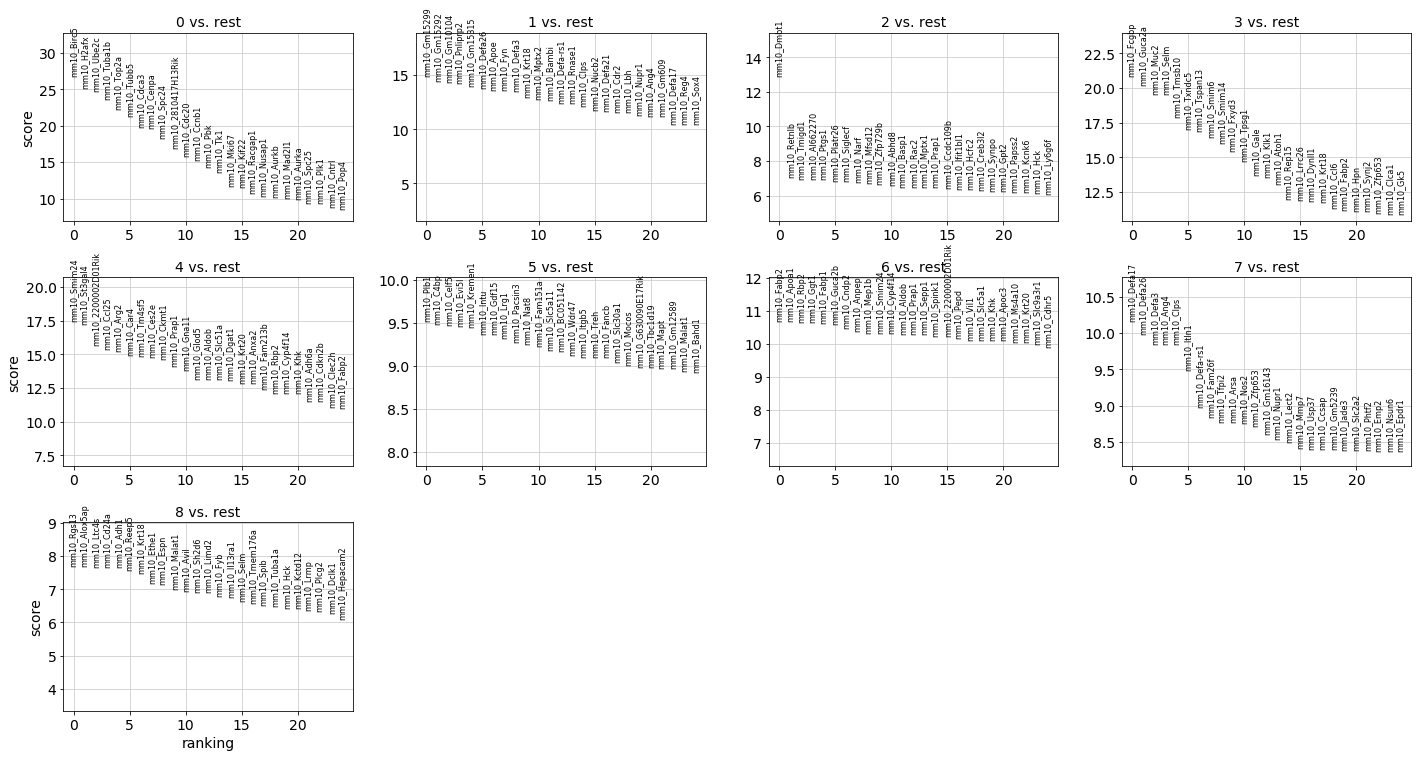

In [44]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by Natranos et al. (2018). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. Clark et al. (2014) has more details.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


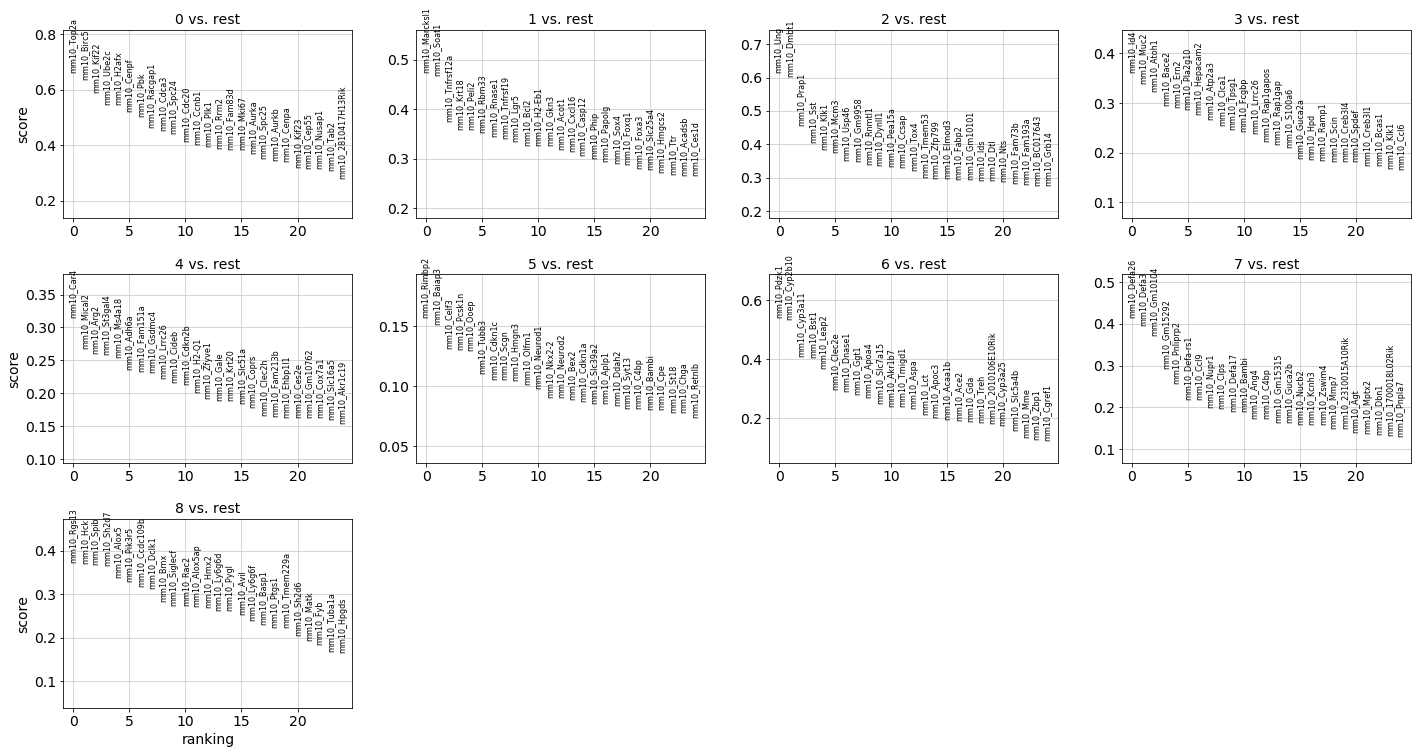

In [45]:
sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Many of the same genes were found in each of the three different tests but let's use the Mann-Whit results to create a list of marker genes.

In [46]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')

/opt/conda/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:389: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


Let's pull out the top 5 ranked genes for each cluster and call the top two "marker genes".

In [47]:
top_hits = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(3)
top_hits

,0,1,2,3,4,5,6,7,8
0,mm10_Birc5,mm10_Gm15299,mm10_Dmbt1,mm10_Fcgbp,mm10_Smim24,mm10_Plb1,mm10_Fabp2,mm10_Defa17,mm10_Rgs13
1,mm10_H2afx,mm10_Gm15292,mm10_Retnlb,mm10_Guca2a,mm10_St3gal4,mm10_C4bp,mm10_Apoa1,mm10_Defa26,mm10_Alox5ap
2,mm10_Ube2c,mm10_Gm10104,mm10_Tmigd1,mm10_Muc2,mm10_2200002D01Rik,mm10_Celf5,mm10_Rbp2,mm10_Defa3,mm10_Ltc4s


In [48]:
marker_genes = [gene for sublist in top_hits.values.tolist() for gene in sublist]
marker_genes

['mm10_Birc5',
 'mm10_Gm15299',
 'mm10_Dmbt1',
 'mm10_Fcgbp',
 'mm10_Smim24',
 'mm10_Plb1',
 'mm10_Fabp2',
 'mm10_Defa17',
 'mm10_Rgs13',
 'mm10_H2afx',
 'mm10_Gm15292',
 'mm10_Retnlb',
 'mm10_Guca2a',
 'mm10_St3gal4',
 'mm10_C4bp',
 'mm10_Apoa1',
 'mm10_Defa26',
 'mm10_Alox5ap',
 'mm10_Ube2c',
 'mm10_Gm10104',
 'mm10_Tmigd1',
 'mm10_Muc2',
 'mm10_2200002D01Rik',
 'mm10_Celf5',
 'mm10_Rbp2',
 'mm10_Defa3',
 'mm10_Ltc4s']

^ FOR THOSE UNFAMILIAR WITH PYTHON: If you are wondering what that command just did, in one line we:
1. Converted every column in our dataframe into a list of genes : top_hits.values
2. Created a list of all the lists: top_hits.values.tolist()
3. Collapse the list of lists into one flat list: [gene for sublist in top_hits.values.tolist() for gene in sublist]

Get a table with the scores and groups.

In [49]:
adata.uns

OrderedDict([('pca',
              {'variance': array([47.869484 , 30.462313 , 24.634266 , 23.196922 , 14.531636 ,
                      10.679135 ,  8.422099 ,  6.8317504,  5.7403765,  5.604498 ,
                       5.4226   ,  4.2202773,  3.9569783,  3.8719363,  3.6134424,
                       3.5722933,  3.4793582,  3.4218497,  3.3705158,  3.304109 ,
                       3.2921014,  3.2848513,  3.2576752,  3.2320116,  3.2080708,
                       3.1913605,  3.1684012,  3.1545177,  3.1462169,  3.125668 ,
                       3.1162999,  3.0995314,  3.0851197,  3.069518 ,  3.0395553,
                       3.0038629,  3.0002651,  2.9892075,  2.982216 ,  2.9463603,
                       2.9408476,  2.9279113,  2.9174154,  2.9084783,  2.9009867,
                       2.8912013,  2.8702388,  2.863319 ,  2.8541758,  2.831313 ],
                     dtype=float32),
               'variance_ratio': array([0.03446793, 0.02193407, 0.01773765, 0.0167027 , 0.01046335,
         

In [50]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p,8_n,8_p
0,mm10_Birc5,4.125979e-158,mm10_Gm15299,2.794569e-50,mm10_Dmbt1,3.621807e-38,mm10_Fcgbp,1.233557e-96,mm10_Smim24,2.485318e-68,mm10_Plb1,1.712064e-21,mm10_Fabp2,1.061106e-26,mm10_Defa17,2.797983e-24,mm10_Rgs13,1.343721e-14
1,mm10_H2afx,1.356516e-139,mm10_Gm15292,1.412736e-47,mm10_Retnlb,1.771256e-12,mm10_Guca2a,5.833617e-91,mm10_St3gal4,1.273481e-66,mm10_C4bp,2.314944e-21,mm10_Apoa1,1.089136e-26,mm10_Defa26,1.687045e-23,mm10_Alox5ap,1.397737e-14
2,mm10_Ube2c,7.645700e-135,mm10_Gm10104,1.195183e-46,mm10_Tmigd1,3.052492e-12,mm10_Muc2,2.300586e-85,mm10_2200002D01Rik,1.208420e-55,mm10_Celf5,2.861344e-21,mm10_Rbp2,1.609285e-26,mm10_Defa3,6.807207e-23,mm10_Ltc4s,1.598913e-14
3,mm10_Tuba1b,3.947420e-123,mm10_Pnliprp2,2.942181e-46,mm10_AI662270,3.759288e-12,mm10_Selm,4.475832e-85,mm10_Ccl25,2.831462e-53,mm10_Evi5l,3.086512e-21,mm10_Ggt1,1.667810e-26,mm10_Ang4,6.911626e-23,mm10_Cd24a,1.609424e-14
4,mm10_Top2a,3.043683e-109,mm10_Gm15315,1.377516e-44,mm10_Ptgs1,3.902458e-12,mm10_Tmsb10,2.065971e-71,mm10_Arg2,3.215186e-52,mm10_Kremen1,3.562758e-21,mm10_Fabp1,1.868431e-26,mm10_Clps,7.457986e-23,mm10_Adh1,1.763908e-14


Often times we want to compare a single cluster to another instead of one vs all

/opt/conda/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:333: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


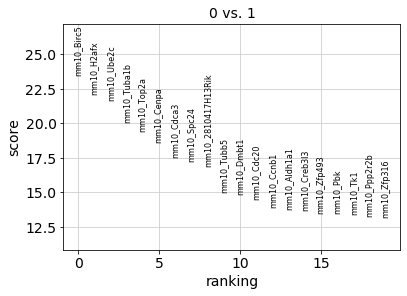

In [51]:
sc.tl.rank_genes_groups(adata, 'louvain', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

Now if you want to save these genes to a .csv you can do

In [52]:
Clust0_v_clust1 = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
Clust0_v_clust1.to_csv('clust0_v_clust1_top100.csv')

Now if we would like to visualize some of the marker genes across the groups
(if there are a lot of small violin plots, double click on them to enlarge)

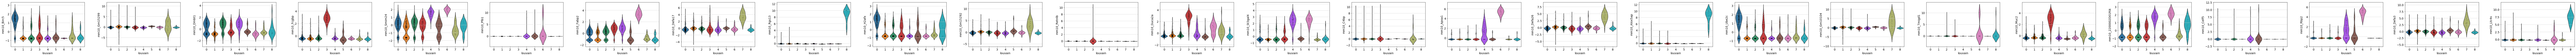

In [53]:
sc.pl.violin(adata, marker_genes, groupby='louvain')

Now let's pretend that using our marker genes we know what each cluster cell type is. We can mark the cell types by the following command.

NOTE: For the sake of this excercise we are marking clusters ARBITRARILY.
Practice on your own time: Look at the gene expression signature for each cluster using the methods described above. Then using the supplementary information from Haber et al. (2017), assign each cluster a cell type label

In [57]:
new_cluster_names = ['Mature Distal E', 'Mature Proximal E','Stem', 'Panepithelial', 'Immature Distal E','Goblet', 'EEC','Immature Proximal E','Tuft']
adata.rename_categories('louvain', new_cluster_names)

Omitting rank_genes_groups/scores as old categories do not match.
Omitting rank_genes_groups/names as old categories do not match.
Omitting rank_genes_groups/logfoldchanges as old categories do not match.
Omitting rank_genes_groups/pvals as old categories do not match.
Omitting rank_genes_groups/pvals_adj as old categories do not match.


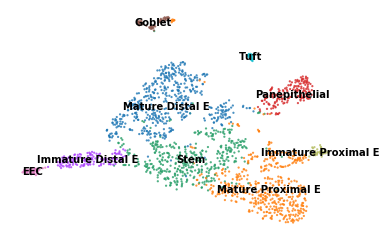

In [58]:
sc.pl.tsne(adata, color=['louvain'], legend_loc='on data' ,title='', frameon=False, legend_fontsize=10, alpha=0.8, size=20, save = 'tsne_cellType_res0_25.pdf')

Now that we annotated the cell types, let us visualize the marker genes.

EXCERCISE: Now that you have marker genes, try plotting the t-SNE plots from earlier again showing the different gene expression profiles of each cluster. Bonus: try plotting them side by side to make a nifty figure

In [70]:
# Your code here

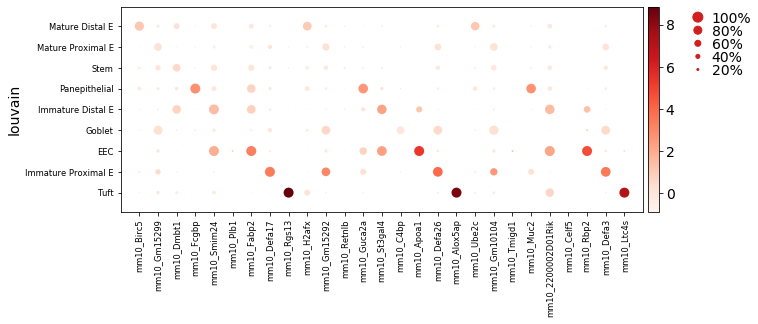

In [59]:
ax = sc.pl.dotplot(adata, marker_genes, groupby='louvain')

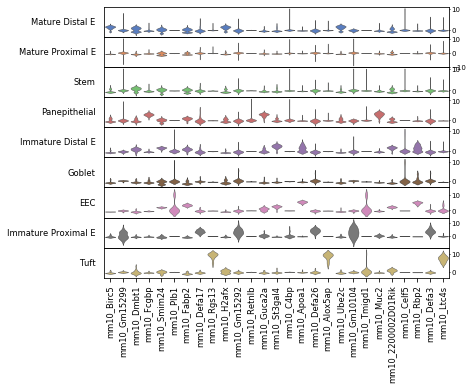

In [63]:
ax = sc.pl.stacked_violin(adata, marker_genes, groupby='louvain', rotation=90)

In [64]:
adata.write(results_file)

In [65]:
adata

AnnData object with n_obs × n_vars = 1855 × 1480 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'gene_ids', 'n_cells', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'draw_graph', 'louvain', 'louvain_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap', 'X_draw_graph_fr', 'X_tsne'
    varm: 'PCs'

## Pseudotime

Infer progression of cells through geodesic distance along the graph [Haghverdi16] [Wolf17i].

Reconstruct the progression of a biological process from snapshot data. Diffusion Pseudotime has been introduced by [Haghverdi16] and implemented within Scanpy [Wolf17]. Here, we use a further developed version, which is able to deal with disconnected graphs [Wolf17i] and can be run in a hierarchical mode by setting the parameter n_branchings>1. We recommend, however, to only use dpt() for computing pseudotime (n_branchings=0) and to detect branchings via paga(). For pseudotime, you need to annotate your data with a root cell. For instance:

adata.uns['iroot'] = np.flatnonzero(adata.obs['cell_types'] == 'Stem')[0]
This requires to run neighbors(), first. In order to reproduce the original implementation of DPT, use method=='gauss' in this. Using the default method=='umap' only leads to minor quantitative differences, though.

To set our root cell I have naturally picked stem cells.

In [66]:
adata = sc.read(results_file)
root_cell = int(np.where(adata.obs['louvain'] == 'Stem')[0][0])
adata.uns['iroot'] = root_cell

/opt/conda/lib/python3.6/site-packages/anndata/readwrite/read.py:440: DeprecationWarning: In a future version, read_h5ad will no longer explicitly support boolean arguments. Specify the read mode, or leave `backed=None`.
  DeprecationWarning,


In [67]:
sc.tl.dpt(adata)

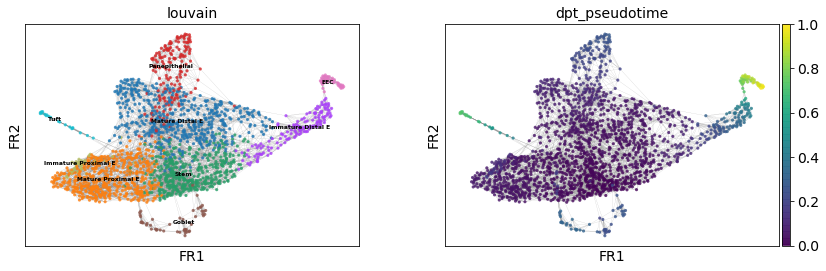

In [68]:
sc.pl.draw_graph(adata, color=['louvain', 'dpt_pseudotime'], layout= 'fr', legend_loc='on data', 
                 edges=True, legend_fontsize=6, alpha=0.8, size=40, save='Pseudo_Time_PBMC3000.png')